# QGA variant analysis

Based on input `input_qga_variants.yaml` and the generated outputs in directories `uqcm_wm.19.07.2024`, `uqcm_wom.19.07.2024`, `bcqo_wm.19.07.2024`, and `bcqo_wom.19.07.2024`.

To generate the outputs run the following script in the command line. This assumes your are running from hte `QGA` directory in a Python environment that has all dependencies installed.

```python src/qga_toolbox/qga_simulator.py inputs/input_qga_variants.yaml```

! Warning: this may take a while. If you want to do a quicker analysis you can lower the number of problem instances considered in the `problem-instance-number` attribute, use that number in the `max_problem` variable below.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

Define a function to load the fidelity arrays easily.

In [2]:
def load_fidelity_array(i_prob, i_state, cloning, mutation):

    dir_path = os.path.join(os.path.dirname(os.getcwd()), 'outputs',f'{cloning}_{mutation}.19.07.2024')
    
    return  np.load(os.path.join(dir_path, f'problem_{i_prob}_state_{i_state}_individual_eig_fidelity.npy'))

## Distribution of the final fidelity

This replicates the part of Fig 4 in [arxiv:2203.15039](https://arxiv.org/abs/2203.15039) for the UQCM-based variants with and without mutation.

We load the final fidelity (fidelity after the last sort operation).

In [3]:
max_problem = 200
max_states = 3  # Originally 10 states where used

final_fid_dict = {
    'bcqo_wm': np.zeros((max_problem, max_states)),
    'bcqo_wom': np.zeros((max_problem, max_states)),
    'uqcm_wm': np.zeros((max_problem, max_states)),
    'uqcm_wom': np.zeros((max_problem, max_states))
    }

for i_prob in range(max_problem):
    for i_state in range(max_states):
        for cloning in ['uqcm', 'bcqo']:
            for mutation in ['wm', 'wom']:
                fidarr = load_fidelity_array(i_prob, i_state, cloning, mutation)
        
                # The indexing of the fidelity array is
                #     (generation-step, individual, eigenstate)
                # -4 corresponds to the state after the last sorting operation
                final_fid_dict[f'{cloning}_{mutation}'][i_prob, i_state] = fidarr[-4,0,0]
    
# Average over the initial populations
final_fid_av = {variant: np.mean(final_fid, axis=1) for variant, final_fid in final_fid_dict.items()}
    

Define the function for the jittering plot.

In [4]:
def jittering_plot(list_of_arrays, labels, jittering_variance = 1, constant_displacement=1, dy=0.1):
    plt.figure(figsize=(10, 6))
    
    for i, data in enumerate(list_of_arrays):
        # Calculate the number of points in each interval (y, y+dy)
        y_vals = np.array(data)
        intervals = np.arange(np.min(y_vals), np.max(y_vals), dy)
        densities = np.array([np.sum((y_vals >= interval) & (y_vals < interval + dy)) for interval in intervals])
        
        # Generate the x-values with jitter
        jitter = []
        for y in y_vals:
            density_index = np.digitize(y, intervals) - 1
            jitter.append(np.random.normal(loc=0, scale=jittering_variance * densities[density_index]/len(y_vals) * constant_displacement))
        
        x_vals = np.array(jitter) + i * constant_displacement
        
        plt.scatter(x_vals, y_vals, alpha=0.6, label=labels[i])
    
    plt.xlim(-constant_displacement, len(list_of_arrays) * constant_displacement)
    plt.xticks(ticks=np.arange(len(labels)) * constant_displacement, labels=labels)
    plt.xlabel('QGA variant')
    plt.ylabel('Final fidelities')
    plt.grid(True)
    plt.show()

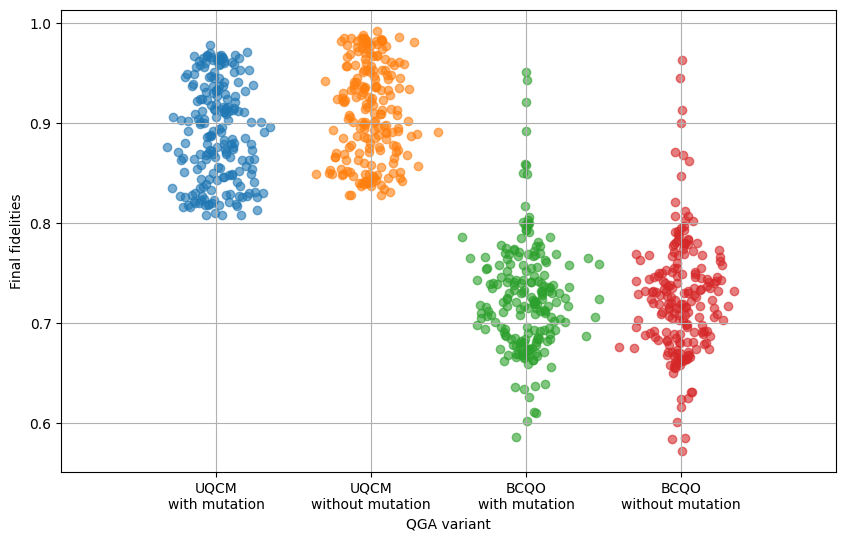

In [5]:
jittering_plot([final_fid_av['uqcm_wm'], final_fid_av['uqcm_wom'], final_fid_av['bcqo_wm'], final_fid_av['bcqo_wom']],
               ['UQCM\nwith mutation', 'UQCM\nwithout mutation', 'BCQO\nwith mutation', 'BCQO\nwithout mutation'],
               jittering_variance=.25)

We can see that there is a linear relation between them.

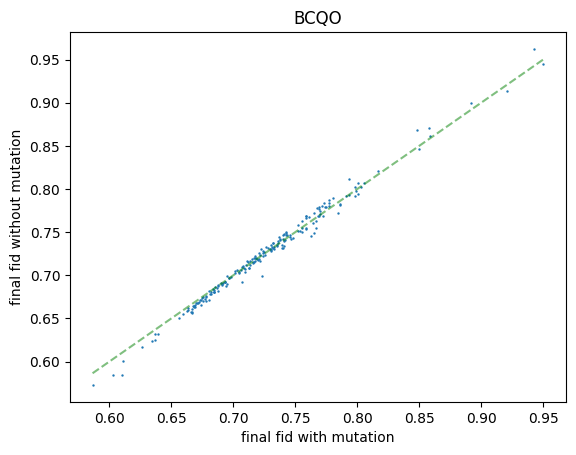

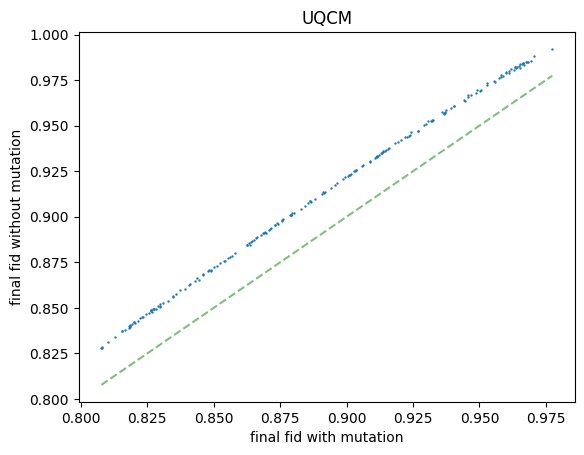

In [13]:
for cloning in ['bcqo', 'uqcm']:
    plt.scatter(final_fid_av[f'{cloning}_wm'],
                final_fid_av[f'{cloning}_wom'],
                s=.5)
    plt.plot([np.min(final_fid_av[f'{cloning}_wm']), np.max(final_fid_av[f'{cloning}_wm'])],
             [np.min(final_fid_av[f'{cloning}_wm']), np.max(final_fid_av[f'{cloning}_wm'])],
             linestyle='--',
             color='g',
             alpha=.5)
    plt.title(cloning.upper())
    plt.xlabel('final fid with mutation')
    plt.ylabel('final fid without mutation')
    plt.show()

In [11]:
from scipy import stats

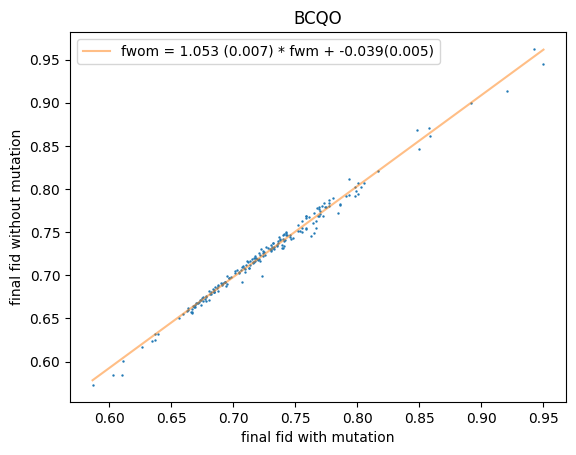

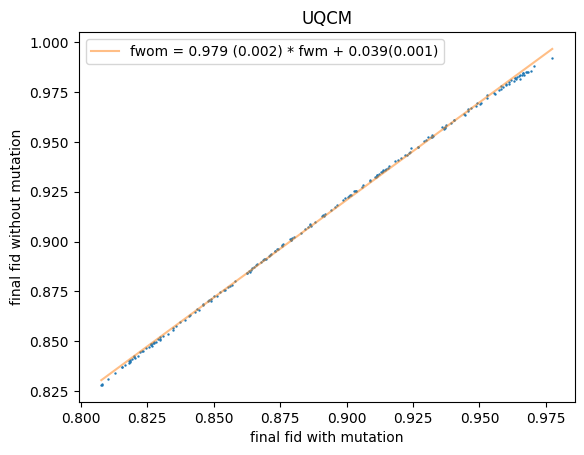

In [20]:
for cloning in ['bcqo', 'uqcm']:
    fwm = final_fid_av[f'{cloning}_wm']
    fwom = final_fid_av[f'{cloning}_wom']

    result = stats.linregress(fwm, fwom)
    plt.scatter(fwm, fwom, s=.5)
    plt.plot([np.min(fwm), np.max(fwm)],
                [result.intercept + result.slope * np.min(fwm),
                result.intercept + result.slope * np.max(fwm)], 
                color='C1',alpha=.5,
                label=f'fwom = {result.slope:.3f} ({result.stderr:.3f}) * fwm + {result.intercept:.3f}({result.intercept_stderr:.3f})')
    plt.xlabel('final fid with mutation')
    plt.ylabel('final fid without mutation')
    plt.title(cloning.upper())
    plt.legend()
    plt.show()

The extreme values, fidelities near $1$, typically require more iterations to converge which accounts for that small deviation.

## Sample evolution for some Hamiltonian

The plot for the variants for mutation if fundamentally different because the mutations here were simulated with the full quantum channel instead of sampling random unitaries.

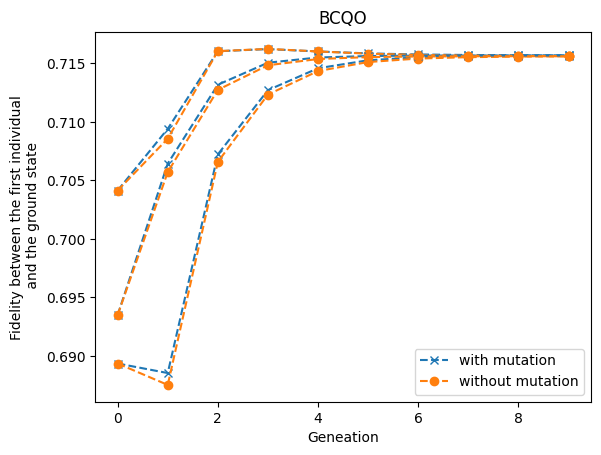

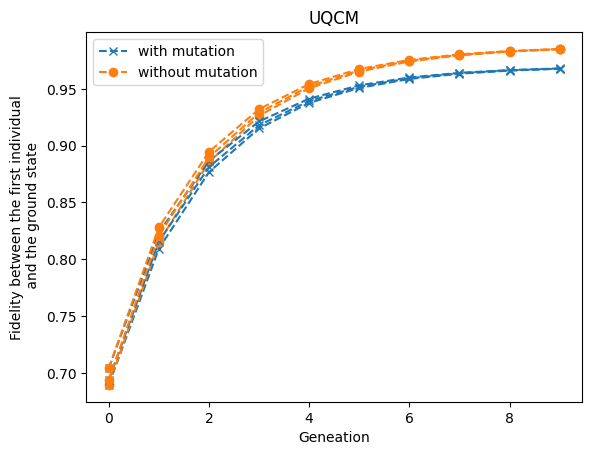

In [26]:
problem_instance = 0

for cloning in ['bcqo', 'uqcm']:
    for i in range(max_states):
        fidarr_wm = load_fidelity_array(problem_instance, i, cloning, 'wm')
        fidarr_wom = load_fidelity_array(problem_instance, i, cloning, 'wom')
        plt.plot(fidarr_wm[1::4,0,0], marker='x', linestyle='--', color='C0', label='with mutation')
        plt.plot(fidarr_wom[1::4,0,0], marker='o', linestyle='--', color='C1', label='without mutation')

    plt.ylabel('Fidelity between the first individual\n and the ground state')
    plt.xlabel('Geneation')
    plt.legend(handles=[
        plt.Line2D([0], [0], marker='x', linestyle='--', color='C0', label='with mutation'),
        plt.Line2D([0], [0], marker='o', linestyle='--', color='C1', label='without mutation')
    ])
    plt.title(cloning.upper())
    plt.show()